In [116]:
import string
import pandas as pd
from transformers import T5TokenizerFast, T5ForConditionalGeneration

### Load Model and Tokenizer

In [117]:

MODEL_CKPT = 'paust/pko-t5-larget'
MODEL_CKPT = 'paust/pko-t5-base'

tokenizer = T5TokenizerFast.from_pretrained(MODEL_CKPT)
# model = T5ForConditionalGeneration.from_pretrained(MODEL_CKPT)

print(MODEL_CKPT)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


paust/pko-t5-base


### Load Data

In [118]:
DATA_PATH = 'data/model_dev_raw/model_dev_raw_v3.pickle'

In [119]:
df_data = pd.read_pickle(DATA_PATH)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14930 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14930 non-null  int64         
 1   create_date    14930 non-null  datetime64[ns]
 2   title          14930 non-null  object        
 3   title_content  14930 non-null  object        
 4   len_tokenized  14930 non-null  int64         
 5   label          14930 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 816.5+ KB


In [120]:
# for idx, row in df_data.iterrows():
#     if idx == 1000:
#         break
#     print(f'Row {idx}')
#     print('input')
#     print(row.title_content)
#     print()
#     print('output')
#     print(row.label)
#     print()
#     print()

### 전처리 계획

- 라벨 앞뒤로 붙은 punctuation 제거
- 라벨 내 key-phrases 중에서 띄어쓰기 기준으로 길이 4 이상인 항목 제거 (보류)

### Preprocess

In [121]:
def remove_ending_seps(string):
    string = string.strip()
    if string[0] in ';.':
        string = string[1:]
    if string[-1] in ';.':
        string = string[:-1]
    return string.strip()

test_case = '; 농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융; '
test_case = ';농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융. '

remove_ending_seps(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [122]:
def remove_quotes(string):
    quotes = '"' + "'"
    key_phrases = [key_phrase.strip() for key_phrase in string.split(';')]

    temp = []
    for key_phrase in key_phrases:
        if key_phrase[0] in quotes and key_phrase[-1] in quotes:
            key_phrase = key_phrase[1:-1]
        temp.append(key_phrase)
    
    return '; '.join(temp)

test_case = "'농협은행'; 'ESG경영'; '상생경영'; '제1회 대한민국 리딩금융 ESG 어워드'; '친환경경영'; '지배구조'; '녹색금융'"

remove_quotes(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [123]:
def preprocess(df):
    df.rename(columns={'title_content': 'input_text', 'label': 'target_text'}, inplace=True)

    df['target_text'] = df['target_text'].apply(remove_ending_seps)
    df['target_text'] = df['target_text'].apply(remove_quotes)
    
    return df

In [124]:
preprocessed_data = preprocess(df_data)

In [125]:
preprocessed_data['len_tokenized_target_text'] = preprocessed_data.target_text.apply(lambda x: len(tokenizer(x)['input_ids']))

(<Axes: >,
 count    14930.000000
 mean        55.724715
 std         21.056362
 min         29.000000
 25%         44.000000
 50%         51.000000
 75%         61.000000
 max        397.000000
 Name: len_tokenized_target_text, dtype: float64)

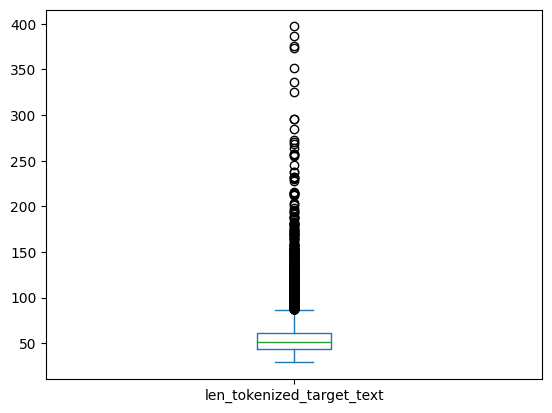

In [126]:
preprocessed_data.len_tokenized_target_text.plot(kind='box'), preprocessed_data.len_tokenized_target_text.describe()

### seq len under 64 lables only

In [127]:
checker = preprocessed_data.len_tokenized_target_text < 64
preprocessed_data = preprocessed_data[checker]
preprocessed_data.len_tokenized_target_text.describe()

count    11683.000000
mean        48.047334
std          7.867650
min         29.000000
25%         42.000000
50%         48.000000
75%         54.000000
max         63.000000
Name: len_tokenized_target_text, dtype: float64

In [128]:
for idx, row in preprocessed_data.iterrows():
    # if idx == 10:
    #     break
    print(f'Row {idx}')
    print('target_text')
    print(row.target_text)
    print()

Row 0
target_text
건조특보; 산불; 진화 작업; 골프 연습; 술자리; 국민의힘; 김기현 대표; 진상 조사; KBS; 보도

Row 2
target_text
판교미래포럼; 초거대-생성AI; 세미나; AI스타트업; 김주영; KAIST 교수; 클라우드; 엣지; 한국 스타트업; K플랫폼

Row 4
target_text
강민경; 유튜브; 구독자 100만; 골드버튼 쪼개기; 이해리; 결혼식; 조회수; 이해리 커버곡; 다비치; 손편지

Row 5
target_text
김민재; 나폴리; 챔피언스리그; 이탈리아 클럽; AC 밀란; 인터 밀란; 8강 진출; 선발 출전; 후반 추가골; 피오트르 지엘린스키

Row 6
target_text
디지털라디오; 방송시대; 지상파 FM라디오방송; 데이터; 전송; 권역; 채널; 과학기술정보통신부; 방송표준방식; 무선설비

Row 8
target_text
인권위; 유엔인권이사회; 북한인권결의; 표결없이 채택; 국제사회; 북한; 비엔나 협약; 대한민국 국민; 영사접견; 통신권 보장

Row 9
target_text
현대모비스; 4연승; 승리; 31승; 외곽포; 론 제이 아바리엔토스; 3점 슛; 플레이오프; 농구; 경기

Row 10
target_text
날씨; 비; 대기의 건조함; 수도권 지역; 미세먼지; 황사; 농도; 낮 기온; 찬 공기; 고온현상

Row 11
target_text
고전 원작; 이혼소송; 흥보 마누라; 발레 첫선극단들; 내용 수정; 젊은층; 여성 관객; 돈키호테; 창극; 이혼 소송 사건

Row 12
target_text
홍김동전; 기상 미션; 아침 식사; 토스트; KBS2TV 예능; 홍진경; 김숙; 조세호; 주우재; 우영

Row 13
target_text
대학동아리; 여성루키; NH농협은행; 아마추어 테니스오픈; 경기도 고양시 삼송리 농협대; 그랜드슬램; 남녀 대학동아리부; 여자 개나리부; 남자 신인부; 농협대 코트

Row 14
target_text
당정; 중증응급센터; 응급실 부족; 대구; 10대 청소년

### Save Preprocessed Data

In [129]:
preprocessed_data.to_pickle('data/model_dev/model_dev_v3.pickle')

### Test Encoding

In [136]:
prefix = "key phrase generation: "

max_input_length = 1024
max_target_length = 64

def preprocess_function(examples):
    inputs = prefix + examples["input_text"]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    labels = tokenizer(examples["target_text"], max_length=max_target_length, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [137]:
model_inputs = preprocess_function(preprocessed_data.iloc[0])

In [138]:
tokenizer.decode(model_inputs['input_ids'])

'key phrase generation: [속보]김기현, 김진태 지사 \'산불 골프\' 조사 지시..."국민 정서 부합하지 않는 언행에 일벌백계" ◇김진태 강원도지사[강원일보DB]속보=건조특보가 내려진 지난달 31일 김진태 강원도지사가 산불 진화 작업이 진행되는 와중에 골프 연습을 하고 술자리를 가졌다는 보도와 관련해 국민의힘 김기현 대표는 7일 진상 조사를 지시했다.윤희석 대변인은 이날 언론 공지에서 "김 지사에 대한 KBS의 보도와 관련해 김 대표는 금일 중앙당 당무감사실을 통해 보도된 내용의 진위 여부를 철저히 조사할 것을 지시했으며 사안의 경중에 따라 책임을 묻는 조치를 취할 것을 사무총장에게 지시했다"고 밝혔다.윤 대변인은 "아울러 김 대표는 당의 기강 확립을 위해 앞으로도 국민 정서에 부합하지 않는 언행에 대해 일체의 관용 없이 일벌백계로 임할 것임을 다시 한번 밝힌다"고 덧붙였다.김 지사는 홍천과 원주 등지에서 산불 진화 작업이 진행 중이던 지난달 31일 오후 조퇴 후 춘천 한 골프연습장에서 20여분간 골프 연습을 했다가 논란이 일자 "이유 여하를 불문하고 산불 위기 상황에 부적절한 행동이었다"고 사과했다.이어 "중요한 시기인데 도민들께 심려를 끼쳐드린 데 대해 송구스럽게 생각하고, 앞으로 이런 일이 없도록 더욱 유념하겠다"고 말했다.이와 관련, KBS는 김 지사가 당시 골프 연습에 이어 지인들과 술자리를 가졌으며 평창에서 산불이 났던 지난달 18일에도 골프연습장을 찾은 것으로 확인됐다고 보도했다.◇홍천 산불[강원도 제공. 재판매 및 DB 금지]김 대표는 이날 오전 신임 원내대표 선출을 위해 열린 의원총회에서 "우리 당을 끌어나가는 지도층에 있는 분들 사이에서 언행이 부적절해 국민들이 눈살을 찌푸리는 일도 있었다"고 지적했다.한편 김 지사 측은 당일 한 시간 연가를 내고 조퇴했지만, 공교롭게 기안자도 그날 연가를 내 지난 3일 연가가 처리됐다고 설명했다.지난달 31일 오후 3시 49분께 홍천군 두촌면 천현리에서 발생한 산불은 산림 당국이 헬기 7

In [139]:
tokenizer.decode(model_inputs['labels'])

'건조특보; 산불; 진화 작업; 골프 연습; 술자리; 국민의힘; 김기현 대표; 진상 조사; KBS; 보도</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

### Model Test

In [147]:
# input_ids = tokenizer("qa question: 당신의 이름은 무엇인가요?", return_tensors='pt').input_ids
# labels = tokenizer("T5 입니다.", return_tensors='pt').input_ids

# input_ids, '\n', labels

# outputs = model(input_ids=input_ids, labels=labels)

# print(f"loss={outputs.loss} logits={outputs.logits}")

In [148]:
# output = model.generate(input_ids, max_length=512)
# tokenizer.batch_decode(output, skip_special_tokens=True)